In [44]:
# do GLM & multiple comparisons
import glob
import os 

import pandas as pd
import nibabel as nb
import numpy as np
from scipy.stats import norm

from nilearn.glm.second_level import SecondLevelModel
from nilearn import plotting
from nilearn.glm.second_level import non_parametric_inference


In [23]:
# get files 
BASE_PATH = os.path.dirname(os.getcwd())
contrasts_path = BASE_PATH + '/contrasts/'
contrasts = sorted(glob.glob(contrasts_path + '*active_minus_sham_mni152_sm08.nii.gz'))


In [30]:
# mask
fsl= os.environ['FSLDIR']
mask = fsl + '/data/standard/MNI152_T1_2mm_brain_mask.nii.gz'

In [31]:
second_design_matrix = pd.DataFrame(
    [1] * len(contrasts),
    columns=['intercept'])

second_level_model = SecondLevelModel(smoothing_fwhm=None, mask_img=mask)
second_level_model = second_level_model.fit(
    contrasts,
    design_matrix=second_design_matrix
)


In [32]:
z_map = second_level_model.compute_contrast(
    second_level_contrast='intercept',
    output_type='z_score'
)

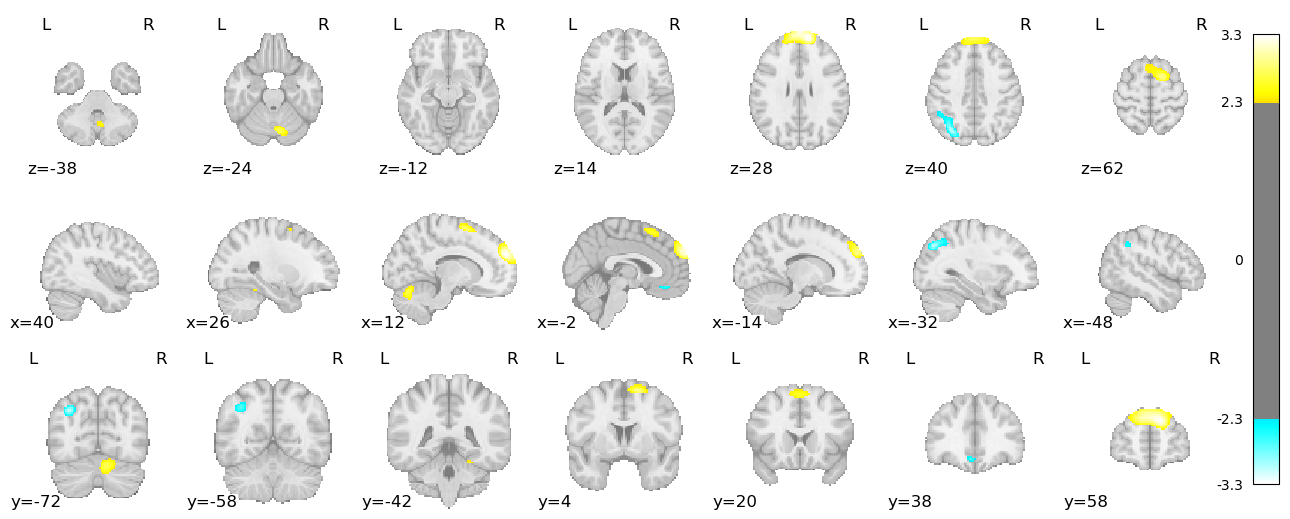

In [77]:
p_val = 0.01
p_unc = norm.isf(p_val)

display = plotting.plot_stat_map(
    z_map,
    threshold=p_unc,
    colorbar=True,
    display_mode='mosaic',
    black_bg=False,
    draw_cross=False)

#fname = PWD+ '/figs/voxel_wise_fear_conditioning_unc_logp3_N53.jpg'
#display.savefig(fname)  # Saves the figure

In [88]:
from nilearn.image import get_data, math_img

p_val = second_level_model.compute_contrast(output_type="p_value")
n_voxels = np.sum(get_data(second_level_model.masker_.mask_img_))
# Correcting the p-values for multiple testing and taking negative logarithm
neg_log_pval = math_img(
    f"-np.log10(np.minimum(1, img * {str(n_voxels)}))",
    img=p_val,
)

<string>:1: RuntimeWarning: divide by zero encountered in log10


In [85]:
from nilearn.glm import threshold_stats_img

_, threshold = threshold_stats_img(z_map, alpha=0.05, height_control="fpr")

In [86]:
threshold

1.9599639845400545

The FDR=.05 threshold is inf


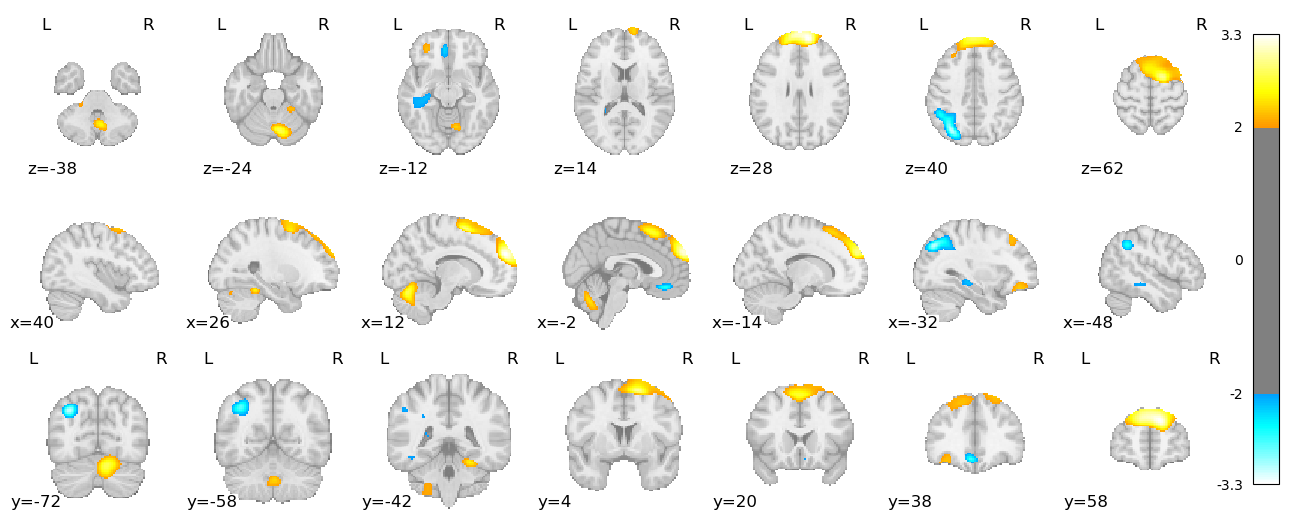

In [87]:

plotting.plot_stat_map(
    z_map,
    threshold=threshold,
    display_mode='mosaic',
    colorbar=True
)
plotting.show()

In [34]:
out_dict = non_parametric_inference(
    contrasts,
    design_matrix=second_design_matrix,
    second_level_contrast='intercept',
    model_intercept=True,
    n_perm=1000,
    two_sided_test=True,
    smoothing_fwhm=None,
    n_jobs=4,
    threshold=0.05,
    mask = mask
)

/home/lauri/.local/lib/python3.11/site-packages/nilearn/mass_univariate/permuted_least_squares.py:986: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/home/lauri/.local/lib/python3.11/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [55]:

signed_p = np.sign(out_dict['t'].get_fdata()) * out_dict['logp_max_t'].get_fdata()
signed_p_img = nb.Nifti1Image(signed_p, out_dict['t'].affine)

print(np.max(np.sign(out_dict['t'].get_fdata())), np.min(np.sign(out_dict['t'].get_fdata())))
print(np.max(np.sign(out_dict['logp_max_t'].get_fdata())), np.min(np.sign(out_dict['logp_max_t'].get_fdata())))

1.0 -1.0
1.0 0.0


In [94]:
out_dict['logp_max_size']

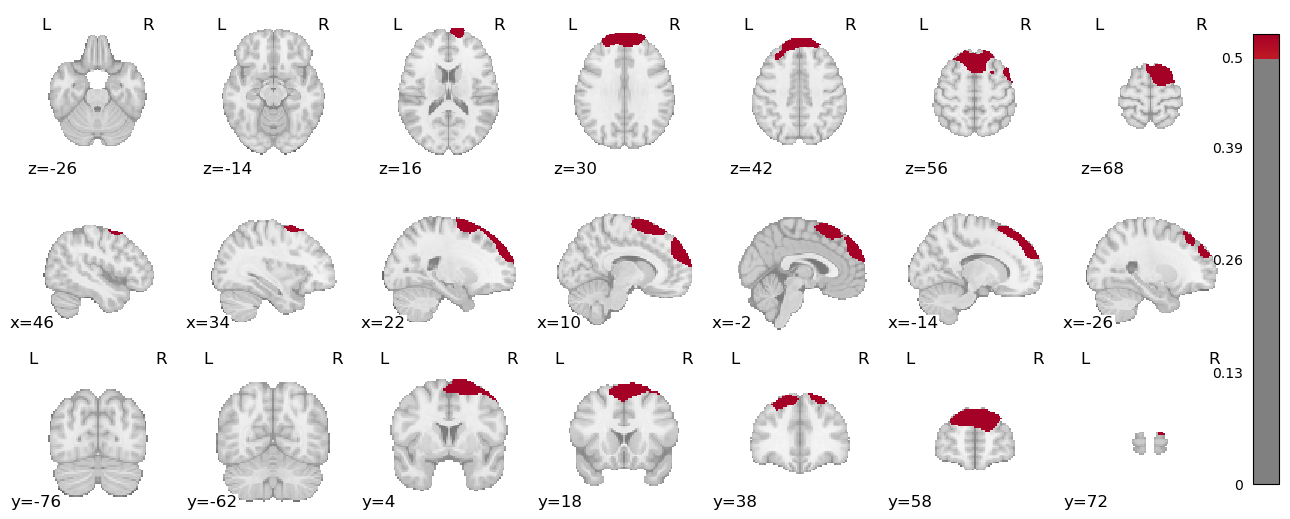

In [97]:
display = plotting.plot_stat_map(
    out_dict['logp_max_size'],
    colorbar=True,
    display_mode='mosaic',
    black_bg=False,
    draw_cross=False,
    cmap='RdYlBu_r',
    threshold = 0.5)

plotting.show()